# Data sanity checks (processed datasets)

This notebook validates that the **processed long-format datasets** used in the experiments are:

- structurally consistent (columns, dtypes, no duplicates),
- temporally valid (per-ticker monotonic timestamps; business-day cadence),
- numerically sane (reasonable distributions / missingness),
- aligned with the downstream backtesting notebooks (**01/02/03**).

We check **both**:
1. `finance_long.parquet` (target = log-returns)
2. `finance_long_logprice_earn.parquet` (target = log-price, plus `is_earnings_window`)

> Tip: run this notebook from `notebooks/` so the project-root detection works out-of-the-box.


In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Project root detection (works whether you run from notebooks/ or repo root)
CWD = Path.cwd()
PROJECT_ROOT = CWD.parent if CWD.name == "notebooks" else CWD
sys.path.append(str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

RET_PATH  = PROCESSED_DIR / "finance_long.parquet"
LOGP_PATH = PROCESSED_DIR / "finance_long_logprice_earn.parquet"

print("RET exists :", RET_PATH.exists(),  "|", RET_PATH)
print("LOGP exists:", LOGP_PATH.exists(), "|", LOGP_PATH)


PROJECT_ROOT: /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension
RET exists : True | /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/finance_long.parquet
LOGP exists: True | /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/finance_long_logprice_earn.parquet


## Load datasets

In [2]:
def load_long(path: Path) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values(["item_id", "timestamp"]).reset_index(drop=True)
    return df

ret  = load_long(RET_PATH)  if RET_PATH.exists()  else None
logp = load_long(LOGP_PATH) if LOGP_PATH.exists() else None

if ret is not None:
    print("returns:", ret.shape, "| columns:", ret.columns.tolist())
if logp is not None:
    print("logprice:", logp.shape, "| columns:", logp.columns.tolist())


returns: (106079, 13) | columns: ['item_id', 'timestamp', 'target', 'dow', 'month', 'is_month_end', 'ret_mean_10', 'ret_vol_10', 'ret_mean_20', 'ret_vol_20', 'range_hl', 'vol_z_10', 'vol_z_20']
logprice: (203463, 14) | columns: ['item_id', 'timestamp', 'target', 'dow', 'month', 'is_month_end', 'is_earnings_window', 'ret_mean_10', 'ret_vol_10', 'ret_mean_20', 'ret_vol_20', 'range_hl', 'vol_z_10', 'vol_z_20']


## 1) Structural checks

In [3]:
REQUIRED_BASE = {"item_id", "timestamp", "target", "dow", "month", "is_month_end"}
TECH_PREFIXES = ("ret_mean_", "ret_vol_", "range_hl", "vol_z_")
EARN_COL = "is_earnings_window"

def structural_report(df: pd.DataFrame, name: str) -> None:
    print(f"\n=== {name} ===")
    print("Rows:", len(df))
    print("Tickers:", df["item_id"].nunique())
    print("Date range:", df["timestamp"].min(), "->", df["timestamp"].max())

    missing_required = REQUIRED_BASE - set(df.columns)
    assert not missing_required, f"{name}: missing required columns: {missing_required}"

    print("\nDtypes:")
    display(df.dtypes)

    dup = df.duplicated(["item_id", "timestamp"]).mean()
    print("\nDuplicate (item_id,timestamp) rate:", dup)
    assert dup == 0.0, f"{name}: found duplicated (item_id,timestamp) rows"

    bad = (
        df.groupby("item_id")["timestamp"]
        .apply(lambda s: (s.diff().dropna() < pd.Timedelta(0)).any())
    )
    bad_items = bad[bad].index.tolist()
    print("Non-monotonic tickers:", len(bad_items))
    assert len(bad_items) == 0, f"{name}: non-monotonic timestamps for: {bad_items[:10]}"

    tech_cols = [c for c in df.columns if c.startswith(TECH_PREFIXES)]
    print("\nTech cols:", tech_cols)
    print("Has earnings flag:", EARN_COL in df.columns)

if ret is not None:
    structural_report(ret, "finance_long (returns)")
if logp is not None:
    structural_report(logp, "finance_long_logprice_earn (log-price + earnings)")



=== finance_long (returns) ===
Rows: 106079
Tickers: 61
Date range: 2019-02-01 00:00:00 -> 2025-12-31 00:00:00

Dtypes:


item_id                 object
timestamp       datetime64[ns]
target                 float32
dow                      int16
month                    int16
is_month_end              int8
ret_mean_10            float64
ret_vol_10             float64
ret_mean_20            float64
ret_vol_20             float64
range_hl               float64
vol_z_10               float64
vol_z_20               float64
dtype: object


Duplicate (item_id,timestamp) rate: 0.0
Non-monotonic tickers: 0

Tech cols: ['ret_mean_10', 'ret_vol_10', 'ret_mean_20', 'ret_vol_20', 'range_hl', 'vol_z_10', 'vol_z_20']
Has earnings flag: False

=== finance_long_logprice_earn (log-price + earnings) ===
Rows: 203463
Tickers: 117
Date range: 2019-02-01 00:00:00 -> 2025-12-31 00:00:00

Dtypes:


item_id                       object
timestamp             datetime64[ns]
target                       float32
dow                            int16
month                          int16
is_month_end                    int8
is_earnings_window           float64
ret_mean_10                  float64
ret_vol_10                   float64
ret_mean_20                  float64
ret_vol_20                   float64
range_hl                     float64
vol_z_10                     float64
vol_z_20                     float64
dtype: object


Duplicate (item_id,timestamp) rate: 0.0
Non-monotonic tickers: 0

Tech cols: ['ret_mean_10', 'ret_vol_10', 'ret_mean_20', 'ret_vol_20', 'range_hl', 'vol_z_10', 'vol_z_20']
Has earnings flag: True


## 2) Missingness & basic statistics

In [4]:
def missingness_and_stats(df: pd.DataFrame, name: str) -> None:
    print(f"\n=== Missingness & stats: {name} ===")
    na = df.isna().mean().sort_values(ascending=False)
    display(na.head(15))

    print("\nTarget summary:")
    display(df["target"].describe())

if ret is not None:
    missingness_and_stats(ret, "returns")
if logp is not None:
    missingness_and_stats(logp, "log-price + earnings")



=== Missingness & stats: returns ===


item_id         0.0
timestamp       0.0
target          0.0
dow             0.0
month           0.0
is_month_end    0.0
ret_mean_10     0.0
ret_vol_10      0.0
ret_mean_20     0.0
ret_vol_20      0.0
range_hl        0.0
vol_z_10        0.0
vol_z_20        0.0
dtype: float64


Target summary:


count    106079.000000
mean          0.000616
std           0.021801
min          -0.432578
25%          -0.008875
50%           0.000859
75%           0.010580
max           0.307108
Name: target, dtype: float64


=== Missingness & stats: log-price + earnings ===


is_earnings_window    0.573859
item_id               0.000000
timestamp             0.000000
target                0.000000
dow                   0.000000
month                 0.000000
is_month_end          0.000000
ret_mean_10           0.000000
ret_vol_10            0.000000
ret_mean_20           0.000000
ret_vol_20            0.000000
range_hl              0.000000
vol_z_10              0.000000
vol_z_20              0.000000
dtype: float64


Target summary:


count    203463.000000
mean          4.789020
std           0.915896
min           1.163787
25%           4.136930
50%           4.831693
75%           5.396400
max           8.664766
Name: target, dtype: float64

## 3) Business-day cadence sanity

Chronos requires a regular frequency. In the backtest we **regularize to Business Days** (see `regularize_to_business_days`),
so here we just verify that timestamps are *at least* consistent with a business-day calendar (no weird spacing issues).


In [5]:
def cadence_check(df: pd.DataFrame, name: str, n_show: int = 5) -> None:
    print(f"\n=== Cadence check: {name} ===")
    sample = df["item_id"].unique()[:n_show]
    for t in sample:
        s = df.loc[df["item_id"] == t, "timestamp"]
        vc = s.diff().dropna().value_counts().head(5)
        print(f"\nTicker {t} — top timestamp deltas:")
        print(vc)

if ret is not None:
    cadence_check(ret, "returns")
if logp is not None:
    cadence_check(logp, "log-price + earnings")



=== Cadence check: returns ===

Ticker AAPL — top timestamp deltas:
timestamp
1 days    1359
3 days     314
4 days      47
2 days      18
Name: count, dtype: int64

Ticker ABBV — top timestamp deltas:
timestamp
1 days    1359
3 days     314
4 days      47
2 days      18
Name: count, dtype: int64

Ticker ABT — top timestamp deltas:
timestamp
1 days    1359
3 days     314
4 days      47
2 days      18
Name: count, dtype: int64

Ticker ADBE — top timestamp deltas:
timestamp
1 days    1359
3 days     314
4 days      47
2 days      18
Name: count, dtype: int64

Ticker ADI — top timestamp deltas:
timestamp
1 days    1359
3 days     314
4 days      47
2 days      18
Name: count, dtype: int64

=== Cadence check: log-price + earnings ===

Ticker AAPL — top timestamp deltas:
timestamp
1 days    1359
3 days     314
4 days      47
2 days      18
Name: count, dtype: int64

Ticker ABBV — top timestamp deltas:
timestamp
1 days    1359
3 days     314
4 days      47
2 days      18
Name: count, dtype: 

## 4) Target distribution plots

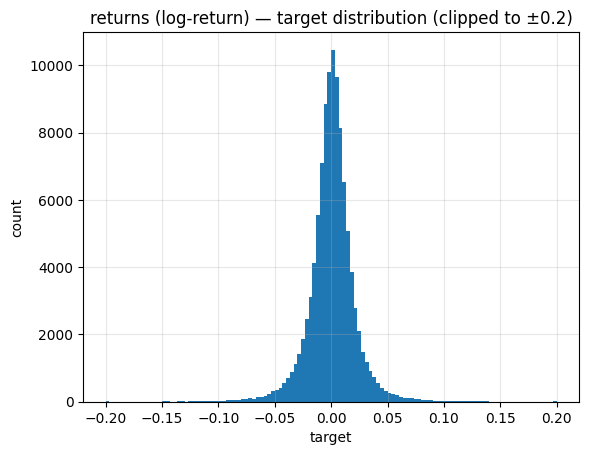

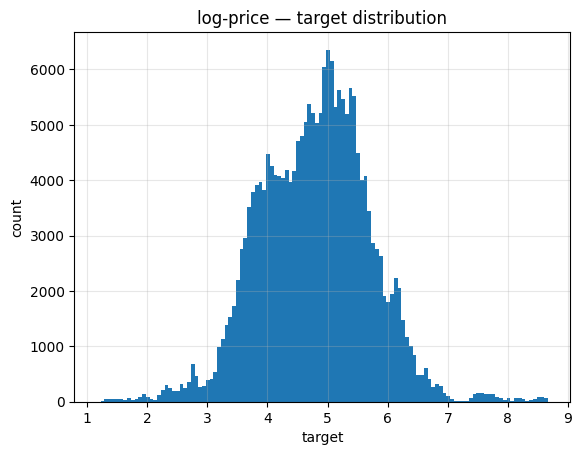

In [6]:
def plot_target_hist(df: pd.DataFrame, name: str, clip: float | None = None) -> None:
    x = df["target"].values
    if clip is not None:
        x = np.clip(x, -clip, clip)
    plt.figure()
    plt.hist(x, bins=120)
    title = f"{name} — target distribution"
    if clip is not None:
        title += f" (clipped to ±{clip})"
    plt.title(title)
    plt.xlabel("target")
    plt.ylabel("count")
    plt.grid(True, alpha=0.3)
    plt.show()

if ret is not None:
    plot_target_hist(ret, "returns (log-return)", clip=0.2)
if logp is not None:
    plot_target_hist(logp, "log-price", clip=None)


## 6) Quick qualitative plot (first 10 tickers)

- For **returns**, we plot cumulative log-returns (`cumsum(target)`).
- For **log-price**, we plot normalized log-price (subtract the first value per ticker).


<Figure size 640x480 with 0 Axes>

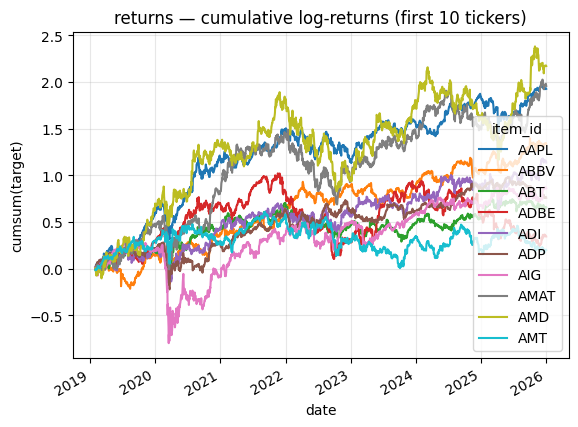

<Figure size 640x480 with 0 Axes>

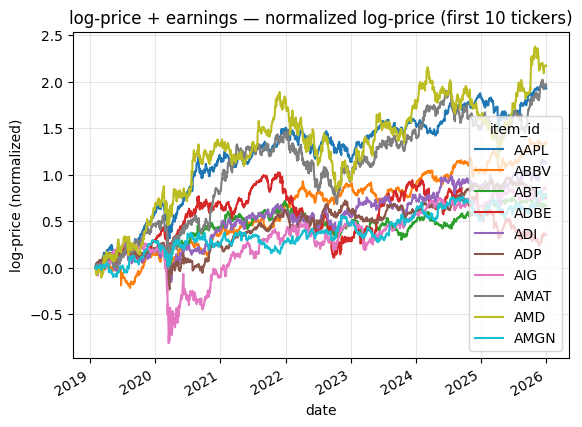

In [8]:
def plot_qualitative(df: pd.DataFrame, name: str, mode: str, n_tickers: int = 10) -> None:
    tickers = df["item_id"].unique()[:n_tickers]
    wide = (
        df[df["item_id"].isin(tickers)]
        .pivot(index="timestamp", columns="item_id", values="target")
        .sort_index()
    )

    if mode == "cum_returns":
        y = wide.cumsum()
        ylabel = "cumsum(target)"
        title = f"{name} — cumulative log-returns (first {n_tickers} tickers)"
    elif mode == "norm_logprice":
        y = wide.apply(lambda s: s - s.iloc[0], axis=0)
        ylabel = "log-price (normalized)"
        title = f"{name} — normalized log-price (first {n_tickers} tickers)"
    else:
        raise ValueError(mode)

    plt.figure()
    y.plot(legend=True)
    plt.title(title)
    plt.xlabel("date")
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.show()

if ret is not None:
    plot_qualitative(ret, "returns", mode="cum_returns", n_tickers=10)
if logp is not None:
    plot_qualitative(logp, "log-price + earnings", mode="norm_logprice", n_tickers=10)


## 7) Alignment check between datasets (shared tickers/dates)

This is a small but important check for **Notebook 03** (returns vs log-price comparison):
we verify that the two datasets overlap on a reasonable number of `(item_id, timestamp)` pairs.


In [9]:
def overlap_check(ret: pd.DataFrame, logp: pd.DataFrame) -> None:
    keys_ret = ret[["item_id","timestamp"]].drop_duplicates()
    keys_logp = logp[["item_id","timestamp"]].drop_duplicates()
    merged = keys_ret.merge(keys_logp, on=["item_id","timestamp"], how="inner")
    print("Shared (item_id,timestamp):", len(merged))
    print("Shared tickers:", merged["item_id"].nunique())
    print("Shared date range:", merged["timestamp"].min(), "->", merged["timestamp"].max())

if (ret is not None) and (logp is not None):
    overlap_check(ret, logp)


Shared (item_id,timestamp): 106079
Shared tickers: 61
Shared date range: 2019-02-01 00:00:00 -> 2025-12-31 00:00:00


## Key takeaways (fill after running)

- Both datasets load correctly and contain the expected columns.
- No duplicate `(item_id, timestamp)` rows; timestamps are monotonic per ticker.
- Missingness is low/controlled (and any known-future covariates are present if expected).
- The targets have plausible distributions (returns are centered near 0; log-price behaves like a smooth trend).
- Earnings flag is present and non-degenerate (both 0s and 1s occur).
- The returns and log-price datasets overlap sufficiently to support Notebook 03 comparisons.
